# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0]
nells = len(ells)
nsplits = 2

In [6]:
s, xiell_split, cov_split = np.load(output_dir+catalog.name+'_1000_mocks_densitySplit_gg_CCF_monopole_cov.npy', allow_pickle=True)
std_split = np.array_split(np.array(np.array_split(np.diag(cov_split)**0.5, nells)), nsplits, axis=1)

### DS2 only

In [7]:
split = 1

xiell = xiell_split[split]
cov = extract_subcovmatrix(s, cov_split, ells, nsplits, split_extract=split)
std = np.array_split(np.diag(cov)**0.5, nells)

In [8]:
mocks_results = np.load(output_dir+catalog.name+'_1000_mocks_2PCF.npy', allow_pickle=True)
ells = [0, 2]
nells = len(ells)

xiell, cov = get_poles(mocks_results, ells)
std = np.array_split(np.diag(cov)**0.5, nells)

## Set power spectrum model

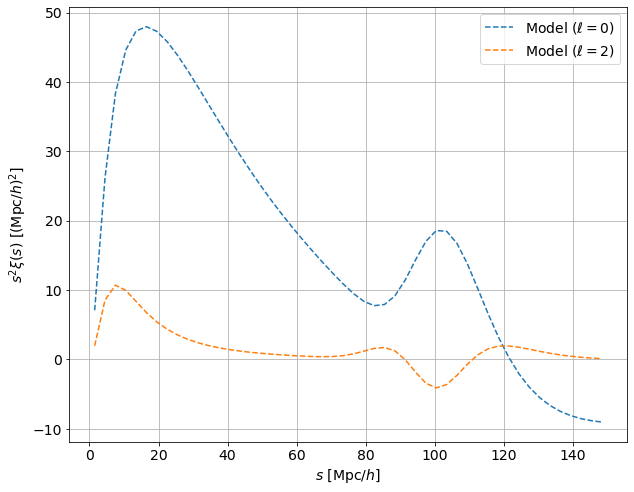

In [9]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.plot_model()

## Fit model to data

In [10]:
# Remove small scales (linear model not valid at small scales)
lower_s_limit = 50 # Mpc/h

# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b': 2, 'broadband_coeffs': broadband_coeffs}

pk_model.fit(fit_params_init=params_init, s_lower_limit=50)

model = pk_model.model(pk_model_params=pk_model.model_popt_dict, broadband_coeffs=pk_model.broadband_coeffs)

Optimal parameters:
{'b': 1.7944610882123424, 'broadband_coeffs': array([ 5.17738861e-01, -1.22888220e-02,  4.98656691e-05, -2.93852404e+00,
        6.27788260e-02, -3.39091457e-04])}

Covariance matrix:
[[ 8.29008488e-04 -4.09598378e-02  4.96559909e-04 -1.33219696e-06
   8.28681666e-04 -5.91818077e-05  3.99046660e-07]
 [-4.09598378e-02  5.27921068e+00 -1.06701262e-01  4.90684046e-04
   1.15054492e-01 -5.15974011e-04 -7.47795145e-06]
 [ 4.96559909e-04 -1.06701262e-01  2.53234325e-03 -1.28157834e-05
  -6.15610976e-03  1.17416554e-04 -4.02160744e-07]
 [-1.33219696e-06  4.90684046e-04 -1.28157834e-05  6.99460212e-08
   4.05289086e-05 -8.53743428e-07  3.34936567e-09]
 [ 8.28681666e-04  1.15054492e-01 -6.15610976e-03  4.05289086e-05
   1.21361879e+01 -3.04175595e-01  1.59311127e-03]
 [-5.91818077e-05 -5.15974011e-04  1.17416554e-04 -8.53743428e-07
  -3.04175595e-01  7.96737808e-03 -4.29559527e-05]
 [ 3.99046660e-07 -7.47795145e-06 -4.02160744e-07  3.34936567e-09
   1.59311127e-03 -4.2955952

In [11]:
pk_model.chi_square()

0.042216234471298825

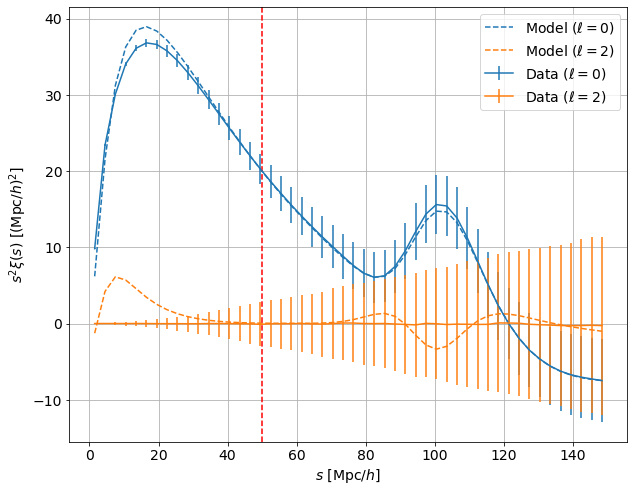

In [12]:
pk_model.plot_model(plot_data=True)